In [2]:
import pandas as pd

all_df = pd.read_csv('./data.csv', low_memory=False)

In [3]:
print(all_df.keys())

Index(['steamId', 'itadPlain', 'itad.position', 'itad.rank', 'steam.name',
       'steam.steam_appid', 'steam.required_age', 'steam.is_free', 'steam.dlc',
       'steam.reviews',
       ...
       'steam.short_description.compound', 'steam.ext_user_account_notice',
       'timestamp', 'year', 'month', 'day', 'daysSinceLaunch', 'price',
       'percentOfReleasePrice', 'isSteamSale'],
      dtype='object', length=131)


In [4]:
pd.to_datetime(all_df['timestamp'] * 1000000000)

0         2016-02-20 00:30:00
1         2016-02-21 00:30:00
2         2016-02-22 00:30:00
3         2016-02-23 00:30:00
4         2016-02-24 00:30:00
                  ...        
4914984   2022-03-02 00:30:00
4914985   2022-03-03 00:30:00
4914986   2022-03-04 00:30:00
4914987   2022-03-05 00:30:00
4914988   2022-03-06 00:30:00
Name: timestamp, Length: 4914989, dtype: datetime64[ns]

In [46]:
all_df.dtypes

steamId                    int64
itadPlain                 object
itad.position              int64
itad.rank                  int64
steam.name                object
                          ...   
day                        int64
daysSinceLaunch            int64
price                    float64
percentOfReleasePrice    float64
isSteamSale                 bool
Length: 131, dtype: object

In [5]:
all_df['time'] = pd.to_datetime(all_df['timestamp'] * 1000000000)

In [6]:
all_df['time']

0         2016-02-20 00:30:00
1         2016-02-21 00:30:00
2         2016-02-22 00:30:00
3         2016-02-23 00:30:00
4         2016-02-24 00:30:00
                  ...        
4914984   2022-03-02 00:30:00
4914985   2022-03-03 00:30:00
4914986   2022-03-04 00:30:00
4914987   2022-03-05 00:30:00
4914988   2022-03-06 00:30:00
Name: time, Length: 4914989, dtype: datetime64[ns]

In [7]:
all_df = all_df.rename({'time': 'ds', 'percentOfReleasePrice': 'y'}, axis='columns')

We want to predict `percentOfReleasePrice` instead of just `price` because of the following:
  - games can start at many prices
  - the starting price of a game is variable (changes over time)
    - e.g. a AAA game in 2015 released at $60, now the base release price is $80
    - It usually jumps in 5-10 dollar increments to keep the consumer happy.
    - @christian can you please find a citation for this or similar metric? Basically want to say that there is a trend in price (but trend is discrete as well)
  - Game launch price is immediately available, if the game is available
  - If we normalize, we'll be able to generalize more (it's more effective when predicting between 0 and 1, rather than having a varying range)
    - We should be normalizing data anyway for ML lol

<AxesSubplot:>

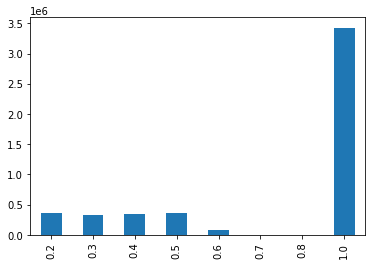

In [35]:
# Look at the average proportions of how the prices are distributed

all_df['y'].round(decimals=1).value_counts().sort_index().plot(kind='bar')

In [8]:
# Split each game into its own dataframe for easier forecasting
dfs = [v for k, v in all_df.groupby('itadPlain')]
len(dfs)

2227

In [39]:
# One dataframe per game, in a list.
dfs[0].head()

,steamId,itadPlain,itad.position,itad.rank,steam.name,steam.steam_appid,steam.required_age,steam.is_free,steam.dlc,steam.reviews,...,steam.ext_user_account_notice,timestamp,year,month,day,daysSinceLaunch,price,y,isSteamSale,ds
3023590,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.455928e+09,2016,2,20,0,19.99,1.0,False,2016-02-20 00:30:00
3023591,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456015e+09,2016,2,21,1,19.99,1.0,False,2016-02-21 00:30:00
3023592,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456101e+09,2016,2,22,2,19.99,1.0,False,2016-02-22 00:30:00
3023593,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456187e+09,2016,2,23,3,19.99,1.0,False,2016-02-23 00:30:00
3023594,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456274e+09,2016,2,24,4,19.99,1.0,False,2016-02-24 00:30:00


In [40]:
# Let's try to naively throw our data into FB Prophet, and see what it spits out.

from prophet import Prophet

m = Prophet()
m.fit(dfs[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -134.097


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       2068.92   0.000727766       79.1295   1.004e-05       0.001      144  LS failed, Hessian reset 
      99       2068.96   1.77372e-06        57.234      0.6525      0.2032      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2068.96   2.06127e-05       50.6233   2.904e-07       0.001      253  LS failed, Hessian reset 
     138       2068.96   2.29474e-08       45.4581     0.03656      0.9634      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [41]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2567,2023-03-02 00:30:00,0.722384,0.416711,0.994110
2568,2023-03-03 00:30:00,0.690779,0.384358,1.014870
2569,2023-03-04 00:30:00,0.671051,0.375199,0.978979
2570,2023-03-05 00:30:00,0.649332,0.343539,0.954121
2571,2023-03-06 00:30:00,0.631082,0.311630,0.941626


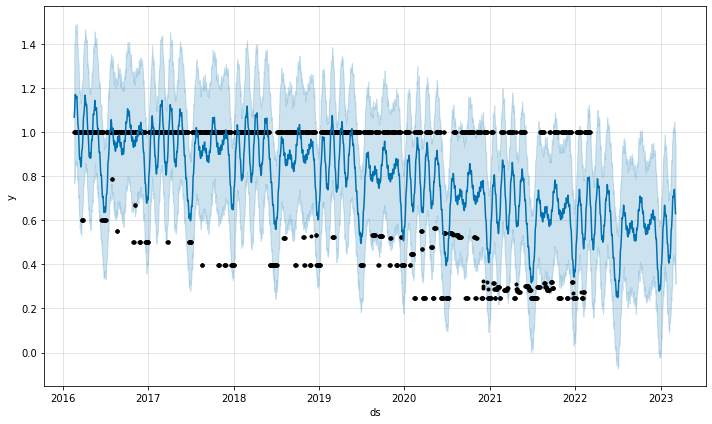

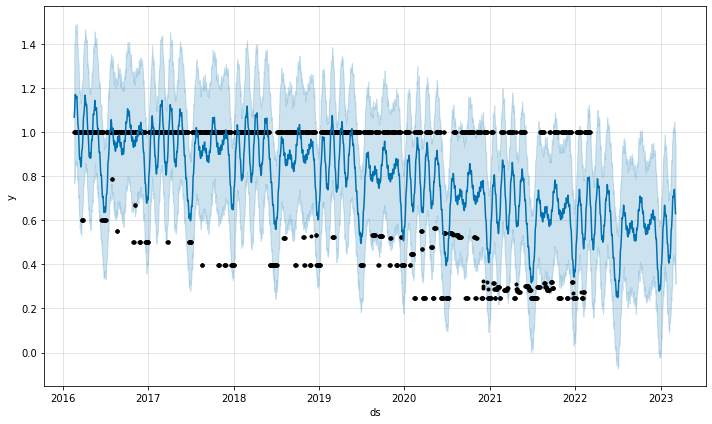

In [43]:
m.plot(forecast)

Hmm uhh..... This doesn't look good. Let's just look at the seasonal components for good measure.

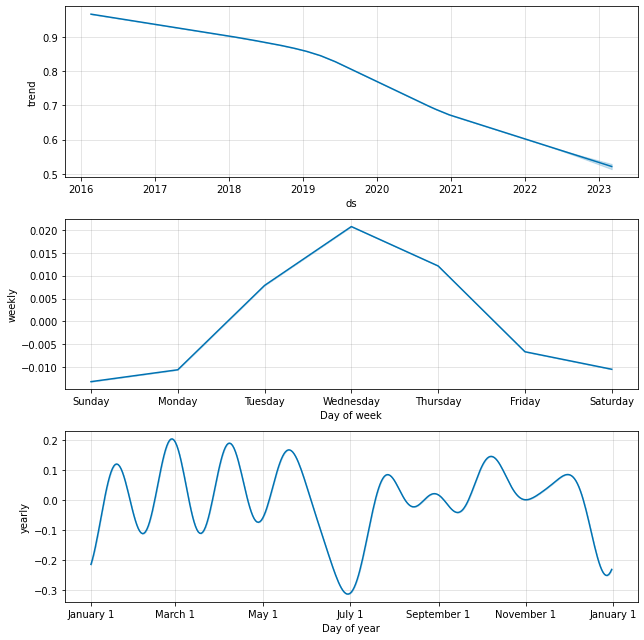

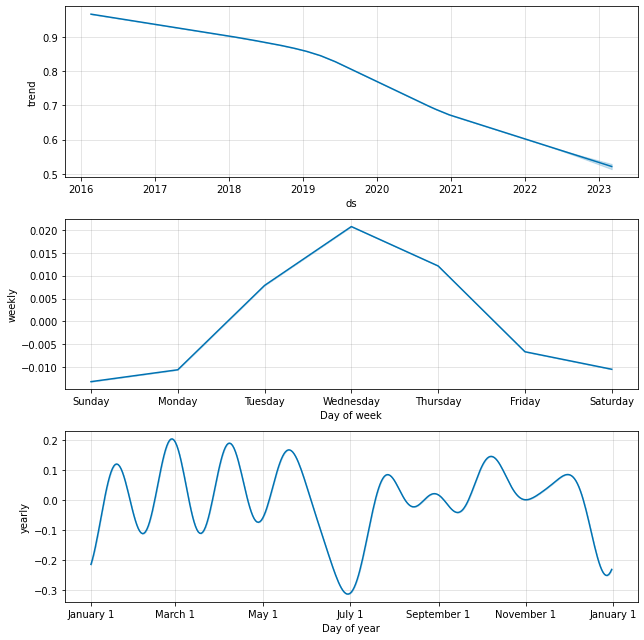

In [18]:
m.plot_components(forecast)

Looks very suspicious. This should definitely not be happening. Ideally, we'd see

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -134.097
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       2068.92   0.000727766       79.1295   1.004e-05       0.001      144  LS failed, Hessian reset 
      99       2068.96   1.77372e-06        57.234      0.6525      0.2032      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2068.96   2.06127e-05       50.6233   2.904e-07       0.001      253  LS failed, Hessian reset 
     138       2068.96   2.29474e-08       45.4581     0.03656      0.9634      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


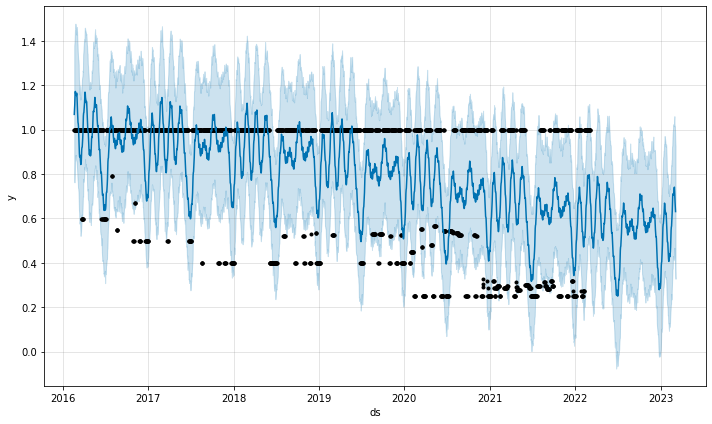

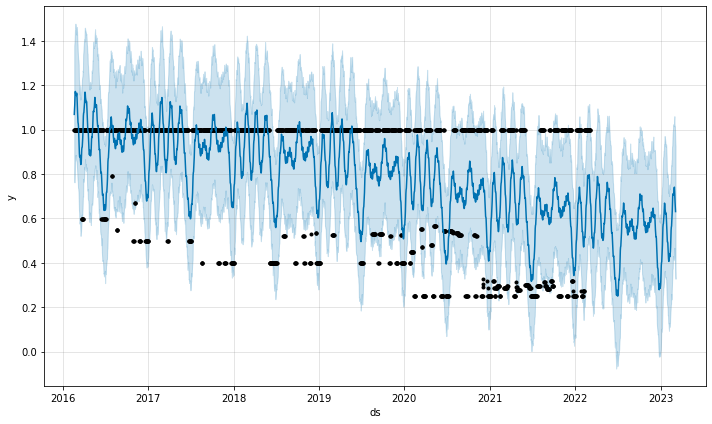

In [45]:
# Let's just try it again with another game to make sure.
m = Prophet()
m.fit(dfs[1732])
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

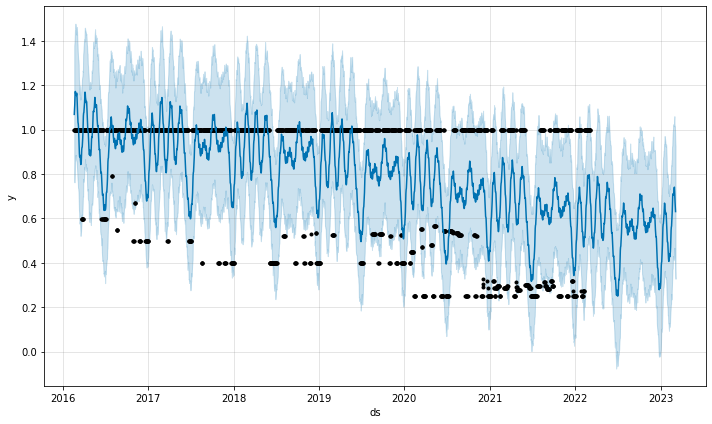

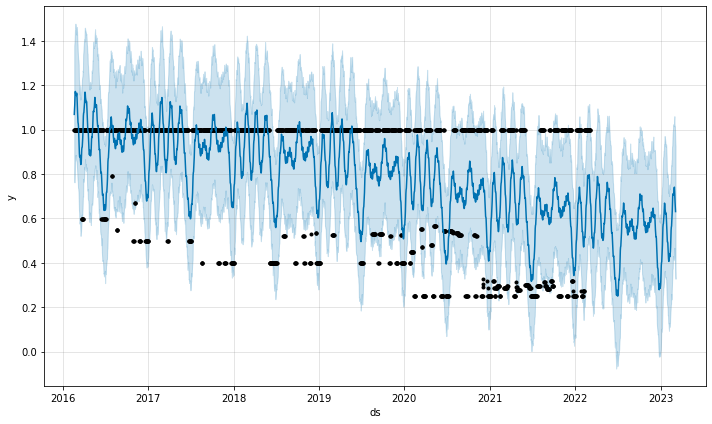

In [46]:
m.plot(forecast)

As we can see, this wasn't very good either. This is probably because sales are always discrete (jump from 100% to 40% price in a day, then jumping back up immediately.) For Prophet, as well as other ML models and the traditional methods (ARIMA, SARIMA, Holt-Winter) both expect a rather continuous distribution.

Let's take another look at our problem again.

We want to be able to predict the prices of games, yes, but why do we want that? We want to predict the prices so that users can decide whether they want to wait or not in order to get a game at a certain price.

That means that the actual proportion of time in a given sliding window (or a given time period) does not matter. Only if it reached it.

This reasoning gives us 2 options:
 - Bucket the `percentOfOriginalPrice` into intervals of 0.8 or 0.1, and predict whether a given interval will show up
    - This is just logistic regression a bunch of times isn't it.
    -